In [1]:
import sklearn
import pandas as pd
train_file = 'taxi-fare-train.csv'
test_file = 'taxi-fare-test.csv'

df_train, df_test = pd.read_csv(train_file), pd.read_csv(test_file)
df_train = pd.get_dummies(df_train, columns=["vendor_id", "payment_type"], prefix=["vendor", "payment"])

df_test = pd.get_dummies(df_test, columns=["vendor_id", "payment_type"], prefix=["vendor", "payment"])
df_train.head()


,rate_code,passenger_count,trip_time_in_secs,trip_distance,fare_amount,vendor_CMT,vendor_VTS,payment_CRD,payment_CSH,payment_DIS,payment_NOC,payment_UNK
0,1,1,1271,3.8,17.5,1,0,1,0,0,0,0
1,1,1,474,1.5,8.0,1,0,1,0,0,0,0
2,1,1,637,1.4,8.5,1,0,1,0,0,0,0
3,1,1,181,0.6,4.5,1,0,0,1,0,0,0
4,1,1,661,1.1,8.5,1,0,1,0,0,0,0


C:\Users\sashaeve\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\sashaeve\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Train mse: 5.141530327995426
Train rmse: 2.2674942840050174
Train r2: 0.9441429371345981
5-fold cross validations results by fold:
0-th fold score: 5.1261709598731855
1-th fold score: 6.900199524840422
2-th fold score: 5.268825535101378
3-th fold score: 5.022233098994278
4-th fold score: 4.597019851347402


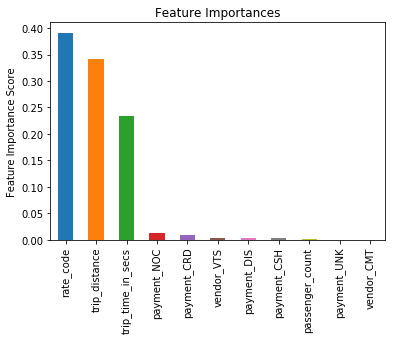

In [2]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams


#encoder = OneHotEncoder()
def cv_fit(model, X, y, important_features=True, cv_folds=5):
    model.fit(X, y)
    train_predictions = model.predict(X)
    train_score = mean_squared_error(y, train_predictions)
    train_r2 = r2_score(y, train_predictions)
    scores = cross_val_score(model, X, y, cv=cv_folds, scoring='neg_mean_squared_error')
    
    print('Train mse: {}'.format(train_score))
    print('Train rmse: {}'.format(train_score**(0.5)))
    print('Train r2: {}'.format(train_r2))
    print('{}-fold cross validations results by fold:'.format(str(cv_folds)))
    for i, item in enumerate(scores):
        print('{}-th fold score: {}'.format(i, -item))
        
    if important_features:
        predictors = [col for col in X.columns]
        feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
X_train, y_train = df_train.loc[:, df_train.columns!='fare_amount'], df_train.loc[:, 'fare_amount']
X_test, y_test = df_test.loc[:, df_test.columns!='fare_amount'], df_test.loc[:, 'fare_amount']

# gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
#         max_depth=1, random_state=0, loss='ls')
# est = gb.fit(X_train, y_train)
# mean_squared_error(y_test, est.predict(X_test))    
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0, loss='ls' )
cv_fit(gbm, X_train, y_train)

In [3]:
# To compare time with ML.NET

gbm_new = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
gbm_new.fit(X_train, y_train)
y_pred = gbm_new.predict(X_train)
mean_squared_error(y_train, y_pred)

8.4600093144369

In [4]:
predictors = [x for x in X_train.columns]
param_test1 = {'n_estimators':[i for i in range(50,100,10)]}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50, max_depth=8, max_features='sqrt',subsample=0.8,random_state=0), 
param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -5.15833, std: 0.86828, params: {'n_estimators': 50},
  mean: -5.07409, std: 0.88164, params: {'n_estimators': 60},
  mean: -5.04325, std: 0.88907, params: {'n_estimators': 70},
  mean: -5.02360, std: 0.90019, params: {'n_estimators': 80},
  mean: -5.00442, std: 0.90098, params: {'n_estimators': 90}],
 {'n_estimators': 90},
 -5.004417133335993)